In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import matplotlib.pyplot as plt
%matplotlib inline  

%load_ext autoreload
%autoreload 2

In [2]:
from collections import deque
import numpy as np
from unityagents import UnityEnvironment

In [3]:
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from utilities import hidden_init

class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc_units=256):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc_units (int): Number of nodes in the hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc_units)
        self.bn1 = nn.BatchNorm1d(fc_units)
        self.fc2 = nn.Linear(fc_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.bn1(self.fc1(state)))
        return F.tanh(self.fc2(x))

class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=256, fc2_units=256, fc3_units=128):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.bns1 = nn.BatchNorm1d(fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, fc3_units)
        self.fc4 = nn.Linear(fc3_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(*hidden_init(self.fc3))
        self.fc4.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        xs = F.leaky_relu(self.bns1(self.fcs1(state)))
        x = torch.cat((xs, action), dim=1)
        x = F.leaky_relu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))
        return self.fc4(x)

In [4]:
from collections import namedtuple, deque
import copy
import numpy as np
import torch.optim as optim
import random
from utilities import OUNoise, ReplayBuffer

BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 128        # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor 
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad(): action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise: action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def add(self, state, action, reward, next_state, done):
        """Save experience in replay memory."""
        # Save experience / reward
        self.memory.add(state, action, reward, next_state, done)

    def update(self):
        """Use random sample from buffer to learn."""
        # Learn, if enough samples are available in memory
        if len(self.memory) > BATCH_SIZE:
            experiences = self.memory.sample()
            self.learn(experiences, GAMMA)

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value

        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences

        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)   
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target

        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [5]:
env = UnityEnvironment(file_name="./Tennis.app")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [6]:
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [7]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


In [8]:
UPDATE_EVERY = 5
N_UPDATES = 10
# best UPDATE_EVERY = 10, N_UPDATES = 10, max_t = 2000: got to 0.61!

def ddpg(env, agent, n_episodes=150, max_t=925, print_every=100):
    best_average_score = 0.0
    scores_deque = deque(maxlen=print_every)
    scores = []
    averaged_scores = []
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        states = env_info.vector_observations
        agent.reset()
        score = np.zeros(2)
        for t in range(max_t):
            actions = [agent.act(np.expand_dims(states[i], axis=0)) for i in [0, 1]]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            one_done = False
            score += rewards
            for i in [0, 1]:
                state, action, reward, next_state, done = states[i], actions[i], rewards[i], next_states[i], dones[i]
                agent.add(state, action, reward, next_state, done)
                if done: one_done = True
            if t % UPDATE_EVERY == 0:
                for j in range(N_UPDATES): agent.update()
            states = next_states
            if one_done: break 
        score = np.max(score)
        scores_deque.append(score)
        scores.append(score)
        if i_episode >= 100:
            data = np.array(scores[i_episode - 100:i_episode])
            averaged_scores.append(np.mean(data))
        else: averaged_scores.append(0.0)
            
        average_score = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score), end="")
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_score))
        if average_score > best_average_score and i_episode > 100:
            best_average_score = average_score
            torch.save(agent.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agent.critic_local.state_dict(), 'checkpoint_critic.pth')
    return scores, averaged_scores

Episode 100	Average Score: 0.00
Episode 200	Average Score: 0.03
Episode 300	Average Score: 0.09
Episode 400	Average Score: 0.16
Episode 500	Average Score: 0.36
Episode 600	Average Score: 0.34
Episode 700	Average Score: 0.48
Episode 800	Average Score: 0.39
Episode 900	Average Score: 0.30
Episode 1000	Average Score: 0.40
Episode 1100	Average Score: 0.51
Episode 1200	Average Score: 0.84
Episode 1300	Average Score: 0.63
Episode 1400	Average Score: 0.76
Episode 1500	Average Score: 0.68
CPU times: user 5h 22min 33s, sys: 56min 28s, total: 6h 19min 2s
Wall time: 4h 28min 49s


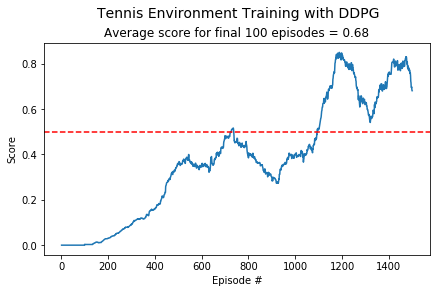

In [9]:
%%time
UPDATE_EVERY = 10
N_UPDATES = 30
n_episodes=1500
max_t=1000
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7654) # 3461 --> 30.67, 4368 --> 32.22
scores, averaged_scores = ddpg(env, agent, n_episodes=n_episodes, max_t=max_t)
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);



In [ ]:
%%time
UPDATE_EVERY = 10
N_UPDATES = 30
n_episodes=750








max_t=1000
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7654) # 3461 --> 30.67, 4368 --> 32.22
scores, averaged_scores = ddpg(env, agent, n_episodes=n_episodes, max_t=max_t)
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);



In [ ]:
UPDATE_EVERY = 8
N_UPDATES = 12
n_episodes=1500
xxx
UPDATE_EVERY = 12
N_UPDATES = 8
n_episodes=1500
xxx
UPDATE_EVERY = 12
N_UPDATES = 24
n_episodes=1500




In [ ]:
%%time
UPDATE_EVERY = 12
N_UPDATES = 24
n_episodes=1500
max_t=1200
# best UPDATE_EVERY = 10, N_UPDATES = 10, max_t = 2000: got to 0.61!

agent = Agent(state_size=state_size, action_size=action_size, random_seed=7654) # 3461 --> 30.67, 4368 --> 32.22
scores, averaged_scores = ddpg(env, agent, n_episodes=n_episodes, max_t=max_t)

In [ ]:
UPDATE_EVERY = 12
N_UPDATES = 24
n_episodes=1500
max_t=1200
agent = Agent(state_size=state_size, action_size=action_size, random_seed=7654) # 3461 --> 30.67, 4368 --> 32.22
scores, averaged_scores = ddpg(env, agent, n_episodes=n_episodes, max_t=max_t)
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);



In [ ]:
UPDATE_EVERY = 10
N_UPDATES = 20
n_episodes=1500
max_t=1200
# best 0.65
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(scores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14);


In [ ]:
UPDATE_EVERY = 5
N_UPDATES = 10
n_episodes=1500
max_t=1000










fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
#pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), averaged_scores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(pscores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14)
plt.show()

In [ ]:
fig = plt.figure(constrained_layout=True)
ax = fig.add_subplot(111)
#plt.plot(np.arange(1, len(scores)+1), scores, averaged_scores)
pscores = [0.0] * 99 + averaged_scores
plt.plot(np.arange(1, len(scores)+1), pscores)

plt.ylabel('Score')
plt.xlabel('Episode #')
#plt.ylim(0, 1)
ax.axhline(y=0.5, color='r', linestyle="dashed")
ax.set_title('Average score for final 100 episodes = %0.2f' % np.mean(pscores[-100:]))
fig.suptitle('        Tennis Environment Training with DDPG', fontsize=14)
plt.show()

In [ ]:
average_scores = []
for i in range(100, len(scores)):
    data = np.array(scores[i - 100:i])
    average_scores.append(np.mean(data))

In [ ]:
action_size

In [ ]:
state_size

In [ ]:
actions = [agent.act(np.expand_dims(states[i], axis=0)) for i in [0, 1]]

In [ ]:
actions np.expand_dims(states[0], axis=0)

In [ ]:
type(actions[0])

In [ ]:
actions[0].shape

In [ ]:
env_info = env.step(actions)[brain_name]

In [ ]:
env_info.vector_observations.shape

In [ ]:
env_info.rewards